<a href="https://colab.research.google.com/github/skc46/Machine_learning_notebooks/blob/master/MNIST_High_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/UAPH4582/PH482_582/blob/main/06_deep_computer_vision_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

#High Accuracy for MNIST

The MNIST dataset is considered as "Hello World" of Machine learning. It contains 70,000 images of handwritten digits by high school students and the employees of the US census Bureau. Using this dataset, one can build and test Machine learning or deep learning models to recognize the hand written digits with high accuracy. In fact, many models have already been trained on this dataset and a very high test accuracy, more than 99.5% (only top 10% models have achieved this score in the Kaggle competition so far ), have been achieved. In this work, we want to build a model using convolutional nueral network with the aim of obtaining highest possible accuracy.

Our architecture will use following layers and techniques;

a) Convolution layers

b) Pooling layers

c) Batch Normalization

d) Dropout

e) Learning Schedule

f) Image Augmentation

g) Ensemble

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, losses, Model, layers


# Dataset Preparation

## Data download

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Visualizing a few images

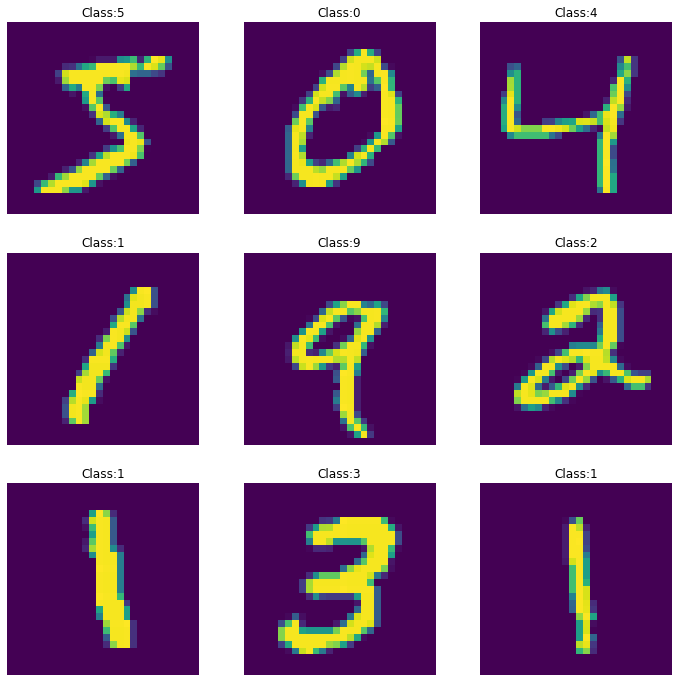

In [9]:
plt.figure(figsize=(12,12))
index=0
for img,lbl in zip(X_train_full[:9,],y_train_full[:9,]):
    index +=1
    plt.subplot(3,3,index)
    plt.imshow(img)
    plt.title("Class:{}".format(lbl))
    plt.axis("off")
plt.show()

## Data scaling and image resizing

In [4]:
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [5]:
print("Train set shape", X_train.shape)
print("Validation set shape", X_valid.shape)
print("Test set shape", X_test.shape)

Train set shape (55000, 28, 28, 1)
Validation set shape (5000, 28, 28, 1)
Test set shape (10000, 28, 28, 1)


# Model building and training


 We first train a simple CNN network and evaluate its performance. Then we will tune the hyperparameters to further improve its performance.

 **Let's train the model**

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0)

Visualizing loss and accuracy with the epochs

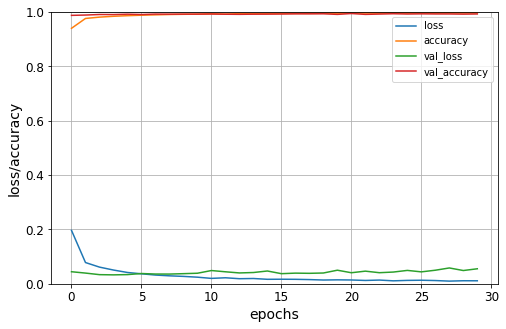

In [13]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel('loss/accuracy')
plt.ylim(0,1)
plt.show()

Evaluation on test set

In [14]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0360 - accuracy: 0.9939


[0.03600914776325226, 0.9939000010490417]

So, our model achieves 99.39% accuracy on the test set. Now, we would like to tune hyperparameters to further enchance the performance.

##Hyperparameter tuning

### Optimizer selection

In [18]:
def model_optimizer(optimizer):
  model = Sequential([
                    Conv2D(32, kernel_size=3, padding="same", activation="relu",input_shape=X_train.shape[1:]),
                    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
                    MaxPool2D(),
                    Flatten(),
                    Dropout(0.25),
                    Dense(128, activation="relu"),
                    Dropout(0.5),
                    Dense(10, activation="softmax")                    
                    ])
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
  return model

wrapper_optimizer = keras.wrappers.scikit_learn.KerasClassifier(model_optimizer)


param_distribs = {
             'optimizer':['sgd', 'adagrad', 'rmsprop', 'adam', 'nadam', 'adamax', 'adadelta']
                   }

optimizer_search_cv = GridSearchCV(wrapper_optimizer, param_distribs, cv=3)

grid_result = optimizer_search_cv.fit(X_train, y_train, epochs=30,batch_size=32, verbose=0)

# summary results
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))
  

573/573 [==============================] - 1s 2ms/step - loss: 0.3606 - accuracy: 0.8971
Best: 0.989582 using {'optimizer': 'nadam'}
0.986327 (0.000692) with: {'optimizer': 'sgd'}
0.963036 (0.003519) with: {'optimizer': 'adagrad'}
0.977145 (0.002627) with: {'optimizer': 'rmsprop'}
0.989273 (0.000322) with: {'optimizer': 'adam'}
0.989582 (0.000792) with: {'optimizer': 'nadam'}
0.988745 (0.001484) with: {'optimizer': 'adamax'}
0.900800 (0.002726) with: {'optimizer': 'adadelta'}


### Activation function tuning

In [19]:
def model_activation(activation='relu'):
  model = Sequential([
                    Conv2D(32, kernel_size=3, padding="same", activation=activation,input_shape=X_train.shape[1:]),
                    Conv2D(64, kernel_size=3, padding="same", activation=activation),
                    MaxPool2D(),
                    Flatten(),
                    Dropout(0.25),
                    Dense(128, activation=activation),
                    Dropout(0.5),
                    Dense(10, activation="softmax")                    
                    ])
  model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam',
              metrics=["accuracy"])
  return model

wrapper_activation = keras.wrappers.scikit_learn.KerasClassifier(model_activation)


param_distribs = {
             'activation':['softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear','elu','selu']
                   }

activation_search_cv = GridSearchCV(wrapper_activation, param_distribs, cv=3)

grid_result = activation_search_cv.fit(X_train, y_train, epochs=30,batch_size=32, verbose=0)

# summary results
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))
  

573/573 [==============================] - 1s 2ms/step - loss: 0.1430 - accuracy: 0.9810
Best: 0.990327 using {'activation': 'relu'}
0.983073 (0.002132) with: {'activation': 'softsign'}
0.990327 (0.000516) with: {'activation': 'relu'}
0.980709 (0.000993) with: {'activation': 'tanh'}
0.986473 (0.002204) with: {'activation': 'sigmoid'}
0.110073 (0.003649) with: {'activation': 'hard_sigmoid'}
0.973418 (0.001279) with: {'activation': 'linear'}
0.983236 (0.001230) with: {'activation': 'elu'}
0.981327 (0.000246) with: {'activation': 'selu'}


### Kernel initializer tuning

In [22]:
def model_kernal_wt(weight_initializer='uniform'):
  model = Sequential([
                    Conv2D(32, kernel_size=3, padding="same", activation='relu', kernel_initializer=weight_initializer, input_shape=X_train.shape[1:]),
                    Conv2D(64, kernel_size=3, padding="same", activation='relu', kernel_initializer=weight_initializer),
                    MaxPool2D(),
                    Flatten(),
                    Dropout(0.25),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(10, activation="softmax")                    
                    ])
  model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam',
              metrics=["accuracy"])
  return model

wrapper_kernel = keras.wrappers.scikit_learn.KerasClassifier(model_kernal_wt)


param_distribs = {
             'weight_initializer':['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
                   }

kernel_search_cv = GridSearchCV(wrapper_kernel, param_distribs, cv=3)

grid_result = kernel_search_cv.fit(X_train, y_train, epochs=30,batch_size=32, verbose=0)

# summary results
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))

573/573 [==============================] - 1s 2ms/step - loss: 0.0658 - accuracy: 0.9889
Best: 0.990309 using {'weight_initializer': 'uniform'}
0.990309 (0.001157) with: {'weight_initializer': 'uniform'}
0.989309 (0.000535) with: {'weight_initializer': 'lecun_uniform'}
0.988509 (0.001070) with: {'weight_initializer': 'normal'}
0.112945 (0.001687) with: {'weight_initializer': 'zero'}
0.989964 (0.001257) with: {'weight_initializer': 'glorot_normal'}
0.989800 (0.000465) with: {'weight_initializer': 'glorot_uniform'}
0.989436 (0.000384) with: {'weight_initializer': 'he_normal'}
0.989309 (0.000321) with: {'weight_initializer': 'he_uniform'}


### Batch size and no. of epochs tuning

In [23]:
def model_batch_size(batch_size=32, epoch=20):
  model = Sequential([
                    Conv2D(32, kernel_size=3, padding="same", activation='relu', kernel_initializer='uniform', input_shape=X_train.shape[1:]),
                    Conv2D(64, kernel_size=3, padding="same", activation='relu', kernel_initializer='uniform'),
                    MaxPool2D(),
                    Flatten(),
                    Dropout(0.25),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(10, activation="softmax")                    
                    ])
  model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam',
              metrics=["accuracy"])
  return model

wrapper_batch = keras.wrappers.scikit_learn.KerasClassifier(model_batch_size)


param_distribs = {
             'batch_size': [16,32,64,128,256],
             'epoch': [10, 20, 30, 40,50]
              }

batch_search_cv = GridSearchCV(wrapper_batch, param_distribs, cv=3)

grid_result = batch_search_cv.fit(X_train, y_train, verbose=0)

# summary results
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))

72/72 [==============================] - 0s 4ms/step - loss: 0.1682 - accuracy: 0.9471
Best: 0.979291 using {'batch_size': 16, 'epoch': 10}
0.979291 (0.001340) with: {'batch_size': 16, 'epoch': 10}
0.979127 (0.000211) with: {'batch_size': 16, 'epoch': 20}
0.976982 (0.001706) with: {'batch_size': 16, 'epoch': 30}
0.978418 (0.000707) with: {'batch_size': 16, 'epoch': 40}
0.978764 (0.001095) with: {'batch_size': 16, 'epoch': 50}
0.975527 (0.000987) with: {'batch_size': 32, 'epoch': 10}
0.976582 (0.001926) with: {'batch_size': 32, 'epoch': 20}
0.977091 (0.002071) with: {'batch_size': 32, 'epoch': 30}
0.976236 (0.000785) with: {'batch_size': 32, 'epoch': 40}
0.977745 (0.000482) with: {'batch_size': 32, 'epoch': 50}
0.976018 (0.001834) with: {'batch_size': 64, 'epoch': 10}
0.973455 (0.000774) with: {'batch_size': 64, 'epoch': 20}
0.973909 (0.001962) with: {'batch_size': 64, 'epoch': 30}
0.975418 (0.001272) with: {'batch_size': 64, 'epoch': 40}
0.975236 (0.000463) with: {'batch_size': 64, 'ep

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", kernel_initializer='uniform'),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu", kernel_initializer='uniform'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/30
860/860 [==============================] - 5s 5ms/step - loss: 0.4745 - accuracy: 0.8495 - val_loss: 0.0588 - val_accuracy: 0.9854
Epoch 2/30
860/860 [==============================] - 4s 4ms/step - loss: 0.0945 - accuracy: 0.9704 - val_loss: 0.0502 - val_accuracy: 0.9858
Epoch 3/30
860/860 [==============================] - 4s 4ms/step - loss: 0.0650 - accuracy: 0.9787 - val_loss: 0.0381 - val_accuracy: 0.9906
Epoch 4/30
860/860 [==============================] - 4s 5ms/step - loss: 0.0548 - accuracy: 0.9830 - val_loss: 0.0382 - val_accuracy: 0.9902
Epoch 5/30
860/860 [==============================] - 4s 4ms/step - loss: 0.0473 - accuracy: 0.9847 - val_loss: 0.0401 - val_accuracy: 0.9900
Epoch 6/30
860/860 [==============================] - 4s 5ms/step - loss: 0.0415 - accuracy: 0.9862 - val_loss: 0.0366 - val_accuracy: 0.9910
Epoch 7/30
860/860 [==============================] - 4s 4ms/step - loss: 0.0363 - accuracy: 0.9895 - val_loss: 0.0364 - val_accuracy: 0.9920
Epoch 

In [15]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0318 - accuracy: 0.9937


[0.03178718313574791, 0.9937000274658203]